## Imports

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen
import torch
from torch import nn
from torch.optim import Adam

## Model definitions

In [19]:
class MultimodalIntegration(nn.Module):
    """
    Combine the outputs from the visual and auditory encoders into a single multimodal representation.
    """
    def __init__(self, multimodal_size, output_size, beta):
        super(MultimodalIntegration, self).__init__()
        self.fc = nn.Linear(multimodal_size, output_size)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        cur = self.fc(x)
        spk, mem = self.lif(cur)
        return spk, mem

## Hyperparameters

## Create models

We have the output from Dylan's visual model. Just use random for audio.

In [20]:
# visual_size = 5  # Length of visual input vector
# audio_size = 3   # Length of audio input vector
hidden_size = 50  # Number of neurons in the hidden layers
beta = 0.9  # Decay rate of the LIF neuron
multimodal_size = hidden_size * 2  # Combined size for multimodal layer

# Output size for the final multimodal representation
output_size = 10

In [21]:
net = MultimodalIntegration(multimodal_size, output_size, beta)

## Load visual representations

In [22]:
npzfile = np.load("visual_outputs.npz")
"""
'inputs'

'labels'
    dim0: training examples; 0-9

'outputs'
    dim0: spks, mems
    dim1: time stpes
    dim2: training examples
    dim3: output neurons
"""
vis_labels = npzfile["labels"] # (9984,)
vis_outputs = npzfile["outputs"] # (2, 25, 9984, 50)


vis_spks = np.transpose(vis_outputs[0,:,:,:], (1, 0, 2)) # (9984, 25, 50)
vis_mems = np.transpose(vis_outputs[1,:,:,:], (1, 0, 2)) # (9984, 25, 50)
# print(vis_spks.shape)

## Run stuff through them (no training)

In [7]:
# # Create example input data
# visual_input = torch.rand((visual_size,))
# audio_input = torch.rand((audio_size,))

# # Generate spike trains from input data
# visual_spike_train = spikegen.rate(visual_input, num_steps=100)
# audio_spike_train = spikegen.rate(audio_input, num_steps=100)

# # Forward pass through the encoding layers
# visual_spk, mem = visual_encoder(visual_spike_train.float())
# audio_spk, mem = audio_encoder(audio_spike_train.float())
# print(audio_spk.shape)

In [23]:
vis_rep = torch.from_numpy(vis_spks[0]).float()
aud_output = torch.from_numpy(vis_spks[0]).float()

print(vis_rep.dtype)

# Concatenate the encoded spikes
combined_spikes = torch.cat((vis_rep, aud_output), dim=1)
print(combined_spikes.shape)

# Forward pass through the integration layer
multimodal_output, mem = net(combined_spikes)
print(multimodal_output.shape)

# print("Multimodal output spike vector:", multimodal_output)

torch.float32
torch.Size([25, 100])
torch.Size([25, 10])


## Training

In [24]:
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = Adam(net.parameters(), lr=0.01)

# Training data is output from visual and audio encoders
vis_spikes = torch.from_numpy(vis_spks).float()
aud_spikes = torch.from_numpy(vis_spks).float() # audio doesn't work so just copy vision
targets = torch.from_numpy(vis_labels).long() # (9984,)

# one-hot encode targets
one_hot_targets = torch.zeros(9984, 10)
for i in range(len(targets)):
    one_hot_targets[i, targets[i]] = 1

In [25]:
# Training loop
num_epochs = 10
num_samples = targets.shape[0]
num_steps = 25  # Number of timesteps for the spike train
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(num_samples):
        target = one_hot_targets[i]

        # Concatenate output spike trains from single sensory encoders
        spike_train = torch.cat((vis_spikes[i,:,:], aud_spikes[i,:,:]), dim=1)

        # Initialize hidden states
        mem1 = net.lif.init_leaky()

        # Accumulate loss over timesteps
        total_loss = 0.0
        optimizer.zero_grad()
        for t in range(num_steps):
            # Forward pass through the network for each timestep
            cur1 = net.fc(spike_train[t])
            spk1, mem1 = net.lif(cur1, mem1)

            # Compute loss for this timestep
            loss = loss_fn(spk1, target)
            total_loss += loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / num_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

        
print("Training complete")

Epoch 1/10, Loss: 1.4471
Epoch 2/10, Loss: 1.2680
Epoch 3/10, Loss: 1.2213
Epoch 4/10, Loss: 1.2032
Epoch 5/10, Loss: 1.1935
Epoch 6/10, Loss: 1.1803
Epoch 7/10, Loss: 1.1751
Epoch 8/10, Loss: 1.1665
Epoch 9/10, Loss: 1.1617
Epoch 10/10, Loss: 1.1653
Training complete


## Inference

### Plotting code

In [59]:
def do_and_plot_model_inference(visual_spikes, audio_spikes, targets, ex=0, hidden_size=hidden_size, audio_type="random"):
    """
        audio_type: "random", "visual_copy"
        
    """
    visual_spk = vis_spikes[ex,:,:]

    if audio_type == "visual_copy":
        audio_spk = visual_spk
    elif audio_type == "random":
        audio_input = torch.rand((hidden_size,))
        audio_spk = spikegen.rate(audio_input, num_steps=25)
    else:
        print("Not an option...")
        return
        
    target = targets[ex]

    # Concatenate the encoded spikes
    combined_spikes = torch.cat((visual_spk, audio_spk), dim=1)

    # Forward pass through the integration layer
    multimodal_output, mem = net(combined_spikes)

    print(f"Vision Input: shape={visual_spk.shape}, spikes={visual_spk.sum()}")
    print(f"Audio: shape={audio_spk.shape}, spikes={audio_spk.sum()}")
    print(f"Multimodal: shape={multimodal_output.shape}, spikes={multimodal_output.sum()}")
    print(f"Ground truth: {target}")

    fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})
    
    # # Plot input spikes
    # splt.raster(visual_spike_train, ax[0], s=5, c="black")
    # ax[0].set_ylabel("Vision Input")
    # ax[0].set_title("Multimodal Integration")
    
    # Plot hidden layer spikes
    splt.raster(visual_spk, ax[0], s=5, c="black")
    ax[0].set_ylabel("Vision Hidden")
    
    # # Plot input spikes
    # splt.raster(audio_spike_train, ax[2], s=5, c="black")
    # ax[2].set_ylabel("Audio Input")
    
    # Plot hidden layer spikes
    splt.raster(audio_spk, ax[1], s=5, c="black")
    ax[1].set_ylabel("Audio Hidden")
    
    # Plot output spikes
    splt.raster(multimodal_output.reshape(num_steps, -1), ax[2], c="black", marker="|")
    ax[2].set_ylabel("Multimodal Output")

    ax[0].set_ylim((-2.45, 51.45))
    ax[1].set_ylim((-2.45, 51.45))
    ax[2].set_ylim([0,9])

    plt.tight_layout()
    plt.show()

    ## Can also plot mem; will show for each neuron
    #plt.plot(memv.detach().numpy())
    #plt.plot(mem.detach().numpy())

### Visual and audio the same

Vision Input: shape=torch.Size([25, 50]), spikes=142.0
Audio: shape=torch.Size([25, 50]), spikes=142.0
Multimodal: shape=torch.Size([25, 10]), spikes=5.0
Ground truth: 5


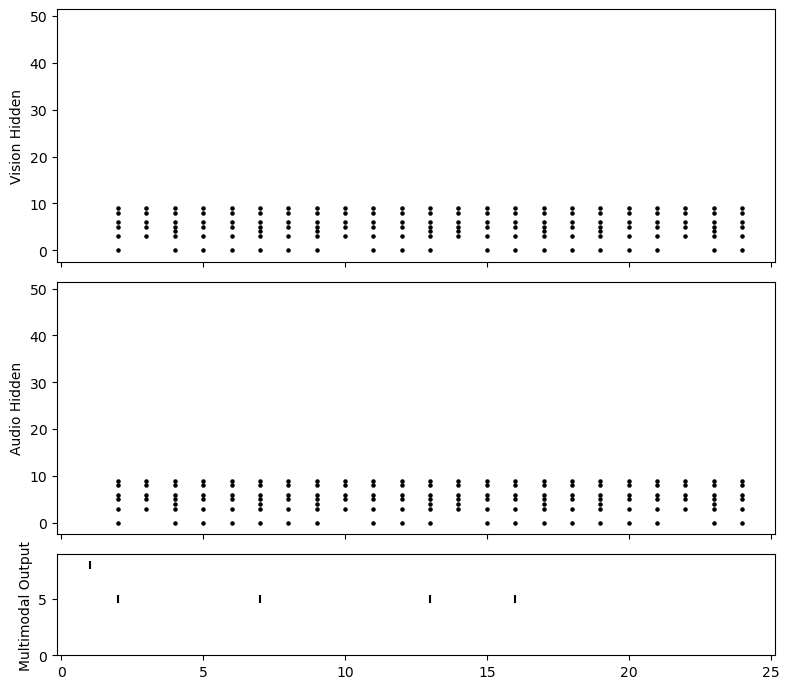

In [60]:
do_and_plot_model_inference(vis_spikes, None, targets, ex=1, audio_type="visual_copy")

### Vision good but audio random

Vision Input: shape=torch.Size([25, 50]), spikes=142.0
Audio: shape=torch.Size([25, 50]), spikes=618.0
Multimodal: shape=torch.Size([25, 10]), spikes=3.0
Ground truth: 5


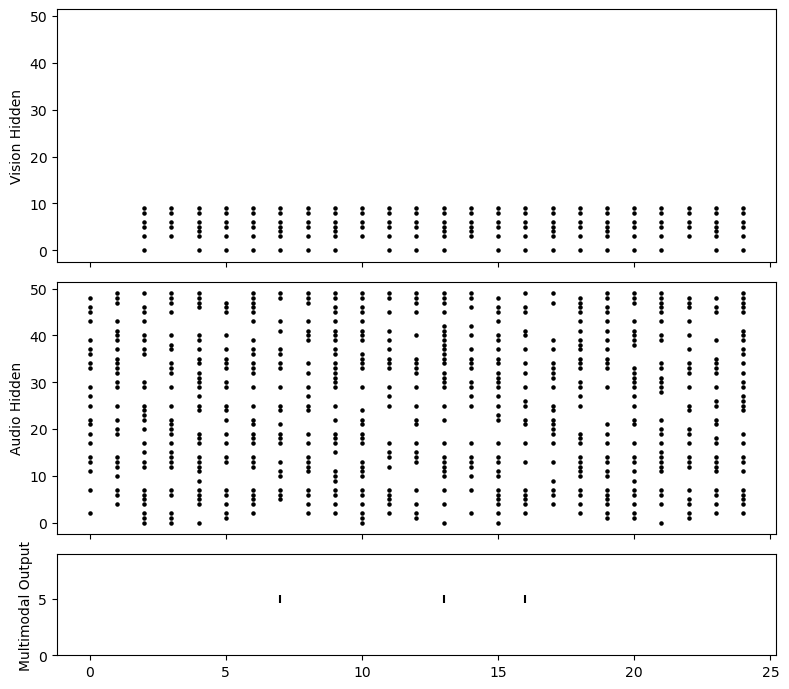

In [62]:
do_and_plot_model_inference(vis_spikes, None, targets, ex=1, audio_type="random")

# Questions and todo

* include audio hidden output
* how to convert multimodal output spike train into final answer -- probability??
* write code for systematically evaluating model
    * in no noise, 25% noise, 50% noise, 75% noise, 100% noise
* train model end-to-end